In [1]:
%%html
<!-- definir quelques styles custom pour l'ensemble du notebook -->
<style>    
    @import url("css/custom_styles.css")
</style>

<center>
    <h1>
    Transformation Et Manipulation Des Données<br>
    </h1>
    MovieLens - Système de recommendations de films par regroupement<br>
    <br>
    <b>Jean-Francois Gagnon</b><br>
    <br>
    420-A56<br>
    <br>
</center>

# Introduction
<br>
<font class="answer">
    
J'ai choisi la base de données [MovieLens Small](https://tinyurl.com/bdhmcfht). Elle se compose de 100836 notes représentant 9742 films. Elle contient également les métadonnées sur 19 genres et des liens sur [TMDB](https://www.themoviedb.org) qui permettront d'augmemter son contenu.
    
Plus spécifiquement, (Voir https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html et décrire en détails le format)
    
    
    
L'objectif de ce projet est de contruire un système de recommentation de films en utilisant les techniques de regroupement vu dans le cours. Les détails du sytème seront abordés plus loins dans ce notebooks

In [2]:
#
# imports utilitaires
#

%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import requests
import seaborn as sns
import time

from bs4 import BeautifulSoup
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler, RobustScaler

from tqdm.notebook import tqdm

#
# imports faisant partie de mes propres module
#

import helpers as hlp
import helpers.Clustering as clstr
import helpers.dataset.MovieLens as mvl
import helpers.WebScraping as scrap
import helpers.jupyter as jup

# Prétraitement

<font class="answer">

Description ici?

In [3]:
#
# parametres configurant nos traitemens
#
configs = hlp.get_configs("config_overrides.json")

#
# obtenir le dataset
#
mvl_dataset = mvl.load(configs.dataset)

## links.csv

<font class="answer">
    
links.csv n'est pas utilisé directement pour le clustering. Cependant, il le sera pour complémenter l'information des autres base de données. Il m'apparait donc imporant de faire un survol rapide.

In [4]:
print("Links", mvl_dataset.links.shape)
print("Head")
display(mvl_dataset.links.head())
clstr.show_na(mvl_dataset.links)
clstr.show_types(mvl_dataset.links)

Links (9742, 3)
Head


,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862


Valeur manquante 8 (0.1%)


,movieId,imdbId,tmdbId
624,791,0113610,NaN
843,1107,0102336,NaN
2141,2851,0081454,NaN
3027,4051,0056600,NaN
5532,26587,0092337,NaN
5854,32600,0377059,NaN
6059,40697,0105946,NaN
7382,79299,0874957,NaN


Types


,movieId,imdbId,tmdbId
Type,int64,object,object


<font class="answer">
    
Il manque quelques liens sur [TMDB](https://www.themoviedb.org/) (ce qui explique le type float64). Les liens [IMDB](https://www.imdb.com/) seront par conséquent utilisés pour fin de web scrapping.

## movies.csv

<font class="answer">
    
Mettre description ici?

In [5]:
print("Movies", mvl_dataset.movies.shape)
print("Head")
display(mvl_dataset.movies.head())
clstr.show_na(mvl_dataset.movies)
clstr.show_types(mvl_dataset.movies)

Movies (9742, 3)
Head


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Valeur manquante 0 (0.0%)
Types


,movieId,title,genres
Type,int64,object,object


<font class="answer">

Tel que décris par MovieLens, *title* contient l'année de parution. Nous allons l'extraire afin d'obtenir une nouvelle variable. *title* sera adressé un pleu plus bas.

In [6]:
def split_title_year(title, regex):
    x = regex.search(title)
    if x:
        title = x.group(1)
        year = x.group(2)
        year = int(year) if year else pd.NA
    else:
        year = pd.NA
    
    return pd.Series({"title": title, "year": year})

title_year_re = re.compile(configs.dataset.title_regex, flags=0)        
title_year = mvl_dataset.movies.title.apply(split_title_year, args=(title_year_re,))

#
# validation de l'extraction
#
print("Informations extraites", title_year.shape)
print("Head")
display(title_year.head())
clstr.show_na(title_year)
clstr.show_types(title_year)

Informations extraites (9742, 2)
Head


,title,year
0,Toy Story,1995
1,Jumanji,1995
2,Grumpier Old Men,1995
3,Waiting to Exhale,1995
4,Father of the Bride Part II,1995


Valeur manquante 12 (0.1%)


,title,year
6059,Babylon 5,<NA>
9031,Ready Player One,<NA>
9091,Hyena Road,<NA>
9138,The Adventures of Sherlock Holmes and Doctor W...,<NA>
9179,Nocturnal Animals,<NA>
9259,Paterson,<NA>
9367,Moonlight,<NA>
9448,The OA,<NA>
9514,Cosmos,<NA>
9515,Maria Bamford: Old Baby,<NA>


Types


,title,year
Type,object,object


<font class="answer">
   
On peut remarquer qu'il manque quelques années de parution. Il est probablement possible de les fixer en utilisant *links.imdbId* avec le web scrapping.

In [7]:
def imdb_scap_year(response, index, imdbId):
    success = False
    if response.ok:
        bs = BeautifulSoup(response.text, "html.parser")

        imdb_info = bs.find("script", attrs={"type": "application/ld+json"})
        imdb_json = json.loads(imdb_info.text)
        date_published = scrap.get_nested_property(imdb_json, ["datePublished"])
        if not success and date_published:
            date_published = pd.to_datetime(date_published)
            year = date_published.year
            success = True

        imdb_info = bs.find("script", attrs={"type": "application/json"})
        imdb_json = json.loads(imdb_info.text)
        releaseYear = scrap.get_nested_property(imdb_json, 
                                                ["props", 
                                                 "pageProps", 
                                                 "mainColumnData", 
                                                 "releaseYear",
                                                 "year"])
        if not success and releaseYear:
            year = releaseYear
            success = True

    if success:
        return (index, year, response.url)
    else:
        return (index, None, response.url)

def imdb_scap_year_apply_results(final_results):
    for index, year, url in final_results:
        if year is None:
            print(url, title_year.title[index], "Failed")
        else:
            title_year.year[index] = year

#    
# corriger year via web scrapping avec imdb
#
year_na = title_year.year.isna()
year_link = mvl_dataset.links.imdbId[ year_na ]

if year_link.shape[0] > 0:
    with hlp.Profile() as year_profile:
        results = scrap.imdb_requests_parallel(year_link,
                                               configs.web_scraping,
                                               imdb_scap_year,
                                               executor=configs.executor)
        imdb_scap_year_apply_results(results)
    print(f"Web scraping year: {year_profile.round_duration(2)}s")

# validation du scapping
clstr.show_na(title_year);

  0%|          | 0/12 [00:00<?, ?it/s]

Web scraping year: 2.38s
Valeur manquante 0 (0.0%)


In [8]:
#
# mettre a jour movies
#
mvl_dataset.movies["year"] = title_year.year.astype(np.int64)

In [9]:
#
# validation effet extraction de l'annee de title
#
imdb_ids = mvl_dataset.links.imdbId[mvl_dataset.links.movieId == mvl_dataset.movies.movieId]

title = mvl_dataset.movies[["movieId", "year"]].copy()
title["title"] = title_year.title.copy()
title["imdbId"] = imdb_ids.copy()

def title_agregate(dataframe):
    return pd.Series({"imdbIds": dataframe.imdbId.unique(),
                      "years": dataframe.year.unique(),
                      "counts": dataframe.movieId.nunique()})

groups = title.groupby("title").apply(title_agregate)
groups.sort_values(by="counts", ascending=False, inplace=True)

display(groups.head())

,imdbIds,years,counts
title,,,
Hamlet,"[0116477, 0040416, 0058175, 0171359, 0099726]","[1996, 1948, 1964, 2000, 1990]",5
"Christmas Carol, A","[0029992, 1067106, 0216621, 0188504]","[1938, 2009, 1999, 1977]",4
"Misérables, Les","[0113828, 0119683, 1707386, 0230534]","[1995, 1998, 2012, 2000]",4
Jane Eyre,"[0116684, 0036969, 0065911, 1229822]","[1996, 1944, 1970, 2011]",4
"Three Musketeers, The","[0108333, 0040876, 0072281, 1509767]","[1993, 1948, 1973, 2011]",4


<font class="answer">
    
Une inspection manuelle de [Hamlet 1996](http://www.imdb.com/title/tt0116477) et [Hamlet 1948](http://www.imdb.com/title/tt0040416) via IMDB permet de voir que l'année juxtaposée au titre est un identifiant unique. Je dois donc garder *title* original.

In [10]:
#
# validation doublons
#
print("Vérifier doublons")
print("Avant:", mvl_dataset.movies.shape)
mvl_dataset.movies.drop_duplicates(inplace=True)
print("Après:", mvl_dataset.movies.shape)

Vérifier doublons
Avant: (9742, 4)
Après: (9742, 4)


<font class="answer">
Aucun doublon

In [11]:
#
# validation modalites genres
#
def show_unique_genres(sort_effectif=False):
    genres_count = {}

    def add(genre):
        if genre in genres_count:
            genres_count[genre] += 1
        else:
            genres_count[genre] = 1
    
    for genres_str in mvl_dataset.movies.genres:
        if genres_str is None:
            add(None)
        else:
            genre_array = genres_str.split(configs.dataset.genre_splitter)
            for genre in genre_array:
                add(genre)

    genres_df = pd.Series(data=genres_count.values(),
                          index=genres_count.keys(),
                          name="# films")

    if sort_effectif:
        #genres_df /= mvl_dataset.movies.shape[0] / 100
        genres_df.sort_values(ascending=False, inplace=True)
    else:
        genres_df.sort_index(inplace=True)

    print("Unique genres:", genres_df.shape[0])
    display(genres_df.to_frame())

show_unique_genres()

Unique genres: 20


,# films
(no genres listed),34
Action,1828
Adventure,1263
Animation,611
Children,664
Comedy,3756
Crime,1199
Documentary,440
Drama,4361
Fantasy,779


<font class="answer">

(no genres listed) semble être en fait des valeurs manquantes.

In [12]:
#
# examiner (no genres listed)
#    
def show_no_genres():
    no_genres_crit = mvl_dataset.movies.genres.str.contains("(no genres listed)", regex=False)
    no_genres = mvl_dataset.movies[no_genres_crit]
    print("(no genres listed)", no_genres.shape[0])
    if no_genres.shape[0] > 0:
        display(no_genres.head())
    return no_genres.index
    
no_genres_index = show_no_genres()

(no genres listed) 34


,movieId,title,genres,year
8517,114335,La cravate (1957),(no genres listed),1957
8684,122888,Ben-hur (2016),(no genres listed),2016
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017
8782,129250,Superfast! (2015),(no genres listed),2015
8836,132084,Let It Be Me (1995),(no genres listed),1995


<font class="answer">
Je vais utiliser le web scrapping pour tenter de remplacer (no genres listed).

In [13]:
def imdb_scap_genres(response, index, imdbId):
    success = False
    if response.ok:
        bs = BeautifulSoup(response.text, "html.parser")

        imdb_info = bs.find("script", attrs={"type": "application/ld+json"})
        imdb_json = json.loads(imdb_info.text)
                
        genres = scrap.get_nested_property(imdb_json, ["genre"])
        if not success and genres:
            success = True
        else:
            error = json.dumps(imdb_json, indent=4)
    else:
        error = response.reason

    if success:
        return (index, genres, response.url, None)
    else:
        
        return (index, None, response.url, error)

def imdb_scap_genres_apply_results(final_results, genres_splitter):
    for index, genres, url, error in final_results:
        if genres is None:
            if False:
                print()
                print(error)
                print()

            print(url, mvl_dataset.movies.title[index], "Failed")
        else:
            mvl_dataset.movies.loc[index, "genres"] = genres_splitter.join(genres)


#
# corriger genres via web scrapping avec imdb
#
genres_imdbIds = mvl_dataset.links.imdbId[no_genres_index]

if genres_imdbIds.shape[0] > 0:
    with hlp.Profile() as genres_profile:
        if True:
            results = scrap.imdb_requests_parallel(genres_imdbIds, 
                                                   configs.web_scraping, 
                                                   imdb_scap_genres,
                                                   executor=configs.executor)
            imdb_scap_genres_apply_results(results, configs.dataset.genre_splitter)
        else:
            # les resultats ne sont pas appliques ici
            # ce code n'existe que pour mesurer le gain du multithreading
            scrap.imdb_requests(genres_imdbIds, 
                                configs.web_scraping, 
                                imdb_scap_genres)
    print(f"Web scraping genres: {genres_profile.round_duration(2)}s")
        
show_unique_genres(sort_effectif=True)
show_no_genres();

  0%|          | 0/34 [00:00<?, ?it/s]

Web scraping genres: 4.22s
Unique genres: 24


,# films
Drama,4375
Comedy,3767
Thriller,1895
Action,1833
Romance,1602
Adventure,1266
Crime,1204
Sci-Fi,982
Horror,979
Fantasy,783


(no genres listed) 0


<font class="answer">
    
Par souci de réduire la quantité de modalités, toutes celles en dessous de 4 individus seront enlevées. Noter que Music et Musical sont synonyme. Finalement, IMAX n'est pas un genre mais bien un format de diffusion.

In [14]:
def clean_genres(genres_str, splitter, to_remove):
    if genres_str is None or not isinstance(genres_str, str):
        return genres_str
    
    genres_list = genres_str.split(splitter)
    genres_set = set(genres_list)
    genres_set -= to_remove
    
    # bien que non portable, par souci d'efficacite
    # handler Music et Musical
    if "Music" in genres_set:
        genres_set.remove("Music")
        genres_set.add("Musical")

    genres_str = splitter.join(genres_set)
    if len(genres_str) == 0:
        genres_str = None

    return genres_str


#
# nettoyer les modalites de genres
#
to_remove = ["IMAX", "Short", "Biography", "Family", "History"]
to_remove = set(to_remove)
cleaned_genres = mvl_dataset.movies.genres.apply(clean_genres, 
                                                 splitter=configs.dataset.genre_splitter,
                                                 to_remove=to_remove)
mvl_dataset.movies["genres"] = cleaned_genres

print("Genres nettoyés")
genres_na = clstr.show_na(mvl_dataset.movies)
print(mvl_dataset.movies.shape)

Genres nettoyés
Valeur manquante 1 (0.0%)


,movieId,title,genres,year
9611,176601,Black Mirror,None,2011


(9742, 4)


<font class="answer">
Certains films avaient 1 seul genre. Après le retrait précédant, 

In [15]:
mvl_dataset.movies.drop(index=genres_na, axis=0, inplace=True, errors="ignore")

# validation retrain NA de genres
show_unique_genres(sort_effectif=True)
clstr.show_na(mvl_dataset.movies);

Unique genres: 18


,# films
Drama,4375
Comedy,3767
Thriller,1895
Action,1833
Romance,1602
Adventure,1266
Crime,1204
Sci-Fi,982
Horror,979
Fantasy,783


Valeur manquante 0 (0.0%)


<font class="answer">

Afin de simplifier la partie exploration, je vais ajouter *imdbId* à *movies.csv* afin d'avoir l'information dans une seule base de données.

In [16]:
#
# ajout imdbId a movies
#
mvl_dataset.movies = pd.merge(mvl_dataset.movies, 
                              mvl_dataset.links[["movieId", "imdbId"]],
                              how="left", 
                              on="movieId")

# pour faciliter la visualization, mettre immediatement imdbId
mvl_dataset.movies.insert(1, 'imdbId', mvl_dataset.movies.pop('imdbId'))

# validation
print("Validation ajout imdbId")
display(mvl_dataset.movies.head())

Validation ajout imdbId


,movieId,imdbId,title,genres,year
0,1,0114709,Toy Story (1995),Children|Adventure|Comedy|Animation|Fantasy,1995
1,2,0113497,Jumanji (1995),Children|Fantasy|Adventure,1995
2,3,0113228,Grumpier Old Men (1995),Romance|Comedy,1995
3,4,0114885,Waiting to Exhale (1995),Romance|Comedy|Drama,1995
4,5,0113041,Father of the Bride Part II (1995),Comedy,1995


## ratings.csv

<font class="answer">
    
Mettre description ici?

In [17]:
print("Ratings", mvl_dataset.ratings.shape)
print("Head")
display(mvl_dataset.ratings.head())
clstr.show_na(mvl_dataset.ratings)
clstr.show_types(mvl_dataset.ratings)

Ratings (100836, 4)
Head


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


Valeur manquante 0 (0.0%)
Types


,userId,movieId,rating,timestamp
Type,int64,int64,float64,int64


<font class="answer">
  
*rating*, bien que montré en nombre flottant, est en fait un système d'étoiles ou la mesure de base est$\frac{1}{2}$. Je garde en quantitatif pour le moment car il semble avantageux pour faire un lien avec les données dans *movies.csv*. L'exploration pourra décider s'il est pertinant de passer en catégoriel si on traite les *ratings.csv* à part (système de recommendation collaboratif).
    
*timestamp* est en fait une date dans le format UTC. Ceci semble suggérer qu'un utilisateur peut avoir voté plus d'une fois pour le même film ou utiliser un système pour automatisé pour biaser les résultats.

In [18]:
#
# verification nombre de votes par couple (utilisateur, film)
#
votes = mvl_dataset.ratings.groupby(by=["userId", "movieId"]).size().max()
print("Nombre de votes par (userId, movieId):", votes)

Nombre de votes par (userId, movieId): 1


<font class="answer">
Un seul vote par utilisateur par film.

In [19]:
#
# verification frequence des votes par utilisateur
#
def dt_sec(data):
    return data.max() - data.min()

def dt_expanded(data):
    utc_min = datetime.utcfromtimestamp(data.min())
    utc_max = datetime.utcfromtimestamp(data.max())
    dt_full = relativedelta(utc_max, utc_min)
    
    full = []
    if dt_full.years > 0:
        full.append(f"{dt_full.years}y")
    elif dt_full.months > 0:
        full.append(f"{dt_full.months}m")
    elif dt_full.days > 0:
        full.append(f"{dt_full.days}d")
    elif dt_full.hours > 0:
        full.append(f"{dt_full.hours}h")
    else:
        if dt_full.minutes > 0:
            full.append(f"{dt_full.minutes}m")

        if dt_full.seconds > 0:
            full.append(f"{dt_full.seconds}s")
    
    return " ".join(full)

def rating_freq(data):
    num = data.shape[0]
    freq = num / dt_sec(data)
    # mHz pour mieux voir ecarts
    return freq * 1000

user_ratings = mvl_dataset.ratings[["userId", "rating", "timestamp"]] \
                          .groupby(by="userId") \
                          .agg(rating_count=("rating", "count"), 
                               dt_sec=("timestamp", dt_sec),
                               dt_expanded=("timestamp", dt_expanded),
                               rating_freq=("timestamp", rating_freq))

rating_freq_stats = user_ratings.rating_freq.describe().to_frame()
rating_cout_stats = user_ratings.rating_count.describe().to_frame()
fastest_users = user_ratings.nlargest(5, "rating_freq")
slowest_users = user_ratings.nsmallest(5, "rating_freq")

html = jup.horizontify(jup.caption_df(fastest_users.style, "User les plus rapide", caption_bold=False), 
                       jup.caption_df(slowest_users.style, "User les moins rapide", caption_bold=False))
jup.display_html(html)

print()
print("Stats générale")
html = jup.horizontify(rating_freq_stats.style, rating_cout_stats.style)
jup.display_html(html)

,rating_count,dt_sec,dt_expanded,rating_freq
userId,,,,
163,23,38,38s,605.263158
147,20,45,45s,444.444444
429,58,147,2m 27s,394.557823
89,518,1393,23m 13s,371.859296
53,20,59,59s,338.983051
,rating_count,dt_sec,dt_expanded,rating_freq
userId,,,,
430,58,273668512,8y,0.000212
543,76,178207424,5y,0.000426



Stats générale


,rating_freq
count,610.000000
mean,39.423830
std,60.607342
min,0.000212
25%,0.040348
50%,16.786110
75%,62.192679
max,605.263158
,rating_count
count,610.000000


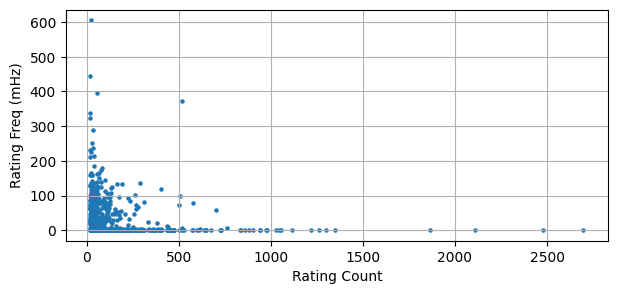

In [20]:
#
# visualiser rating_count vs rating_freq
#
def rating_count_vs_freq(user_ratings, critOutliers=None, figsize=(7, 3)):
    plt.figure(figsize=figsize)
    
    if critOutliers is None:
        plt.scatter(user_ratings.rating_count, user_ratings.rating_freq, s=5)
    else:
        outliers = user_ratings[critOutliers]
        plt.scatter(outliers.rating_count, outliers.rating_freq, s=5, label="Outliers")
        
        inliers = user_ratings[~critOutliers]
        plt.scatter(inliers.rating_count, inliers.rating_freq, s=5, label="Inliers")
        
        plt.legend()
    
    plt.grid(True)
    plt.xlabel("Rating Count")
    plt.ylabel("Rating Freq (mHz)")
    plt.show()
    
rating_count_vs_freq(user_ratings)

<font class="answer">
Les utilisateurs ont votés relativement souvent (20 votes ou plus) mais la distribution est très allongée et fortement concentrée dans les valeurs faible. Le graphe ci-haut suggère que les votes semblent avoir étés fait de façon très rapide. Pour illustrer, le user *163* aurait voté 23 fois en 38 secondes (~2 secondes par vote). mais le user *172* aurait pris 1 an pour ses 26 votes. Faute d'information supplémentaire, je suspecte un système automatisé et enlève les utilisateurs ayant une fréquence de vote jugée trop élevée.<br><br>
    
En absolue:
$$
\begin{align}
threshold &= Q_3 + 1.5 * IQR\\
          &= 62.19 + 1.5 * (62.19 - 0.04)\\
          &= 155.36\\
\end{align}
$$
  
Une approche basée sur le clustering, plus particulièrement DBSCAN, trouvera les éléments isolés dans le graphe.

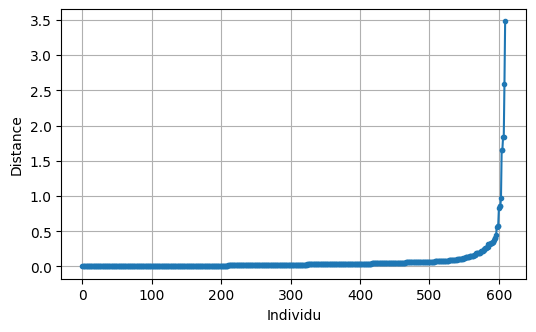

DBSCAN optimal parameters
eps: 0.44000000000000017
min_samples: 3
silhouette score: 0.7059
# clusters: 3 + ouliers


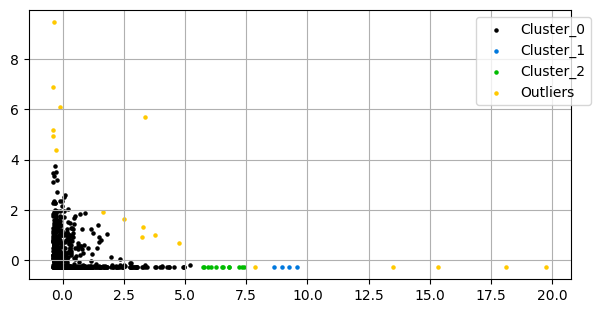

In [21]:
coords = RobustScaler().fit_transform(user_ratings[["rating_count", "rating_freq"]])
clstr.dbscan_eps_analysis(coords, figsize=(6, 3.5))

eps_, min_samples_ = clstr.dbscan_parameters_analysis(coords, 
                                                      np.arange(0.25, 0.45, 0.01),
                                                      range(2, 20))
dbscan_ = clstr.dbscan_init(coords, eps_, min_samples_)
clstr.show_clusters(coords, 
                    user_ratings.index, 
                    dbscan_.labels_, 
                    figsize=(7, 3.5),
                    text_alpha=0, 
                    marker_size=5)

Nombre de user outliers 29


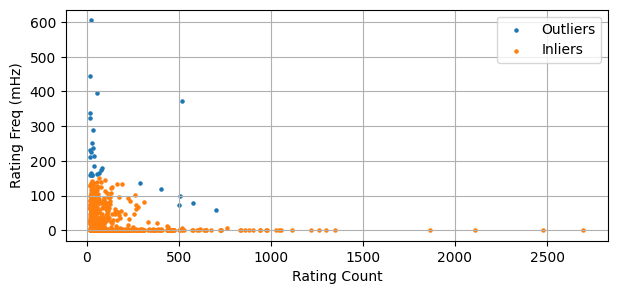

In [22]:
#
# detecter les user juges outliers
#
critA = dbscan_.labels_ == -1

# dbscan marque certaines basses frequences 
# s'assurer de les garder
critB = user_ratings.rating_freq > 1

# IQR threshold
critC = user_ratings.rating_freq >= 155.36

# combiner tous les criteres d'outliers
critOutliers = critA & critB | critC

print("Nombre de user outliers", np.count_nonzero(critOutliers))
rating_count_vs_freq(user_ratings, critOutliers)

In [23]:
#
# enlever les user juges outliers
#
user_to_remove = user_ratings[critOutliers].index.to_list()
user_to_remove = mvl_dataset.ratings.userId.isin(user_to_remove)
user_to_remove = mvl_dataset.ratings[user_to_remove]

print("ratings avant retrait users:", mvl_dataset.ratings.shape[0])
mvl_dataset.ratings.drop(user_to_remove.index, inplace=True, errors="ignore")
print("ratings après retrait users:", mvl_dataset.ratings.shape[0])

ratings avant retrait users: 100836
ratings après retrait users: 96549


<font class="answer">
Pour movies.csv, il apparait judicieux d'extraire quelques statistiques sur *rating*

In [24]:
def etendue(ratings):
    return ratings.max() - ratings.min()

def iqr(ratings):
    return ratings.quantile(0.75) - ratings.quantile(0.25)

def mode(ratings):
    # prendre le mode le plus grand
    return ratings.mode().iloc[-1]

def median_keep_category(ratings):
    # garder les modalites de ratings si nombre de valeurs est impaire
    return ratings.quantile(interpolation="nearest")

def join_name(multi_index_name):
    if "" in multi_index_name:
        return multi_index_name[0]
    else:
        return "_".join(multi_index_name)


#
# creer des variables pour movies
#
ratings_stats = mvl_dataset.ratings[["movieId", "rating"]] \
                           .groupby(by="movieId") \
                           .agg(["count", ("mode", mode), "mean", ("median", median_keep_category)])
ratings_stats.columns = [join_name(a) for a in ratings_stats.columns.to_flat_index()]
ratings_stats.reset_index(inplace=True)
print("Rating stats", ratings_stats.shape)
print("Head")
display(ratings_stats.head().round(2))

Rating stats (9461, 5)
Head


,movieId,rating_count,rating_mode,rating_mean,rating_median
0,1,204,4.0,3.91,4.0
1,2,103,4.0,3.43,3.5
2,3,47,3.0,3.27,3.0
3,4,7,3.0,2.36,3.0
4,5,44,3.0,3.02,3.0


In [25]:
#
# detailler les valeurs manquantes
#
clstr.show_na(ratings_stats);

Valeur manquante 0 (0.0%)


In [26]:
#
# valider que ratings_stats contient bien les meme films que movies.csv
#
movies_ratings = pd.merge(mvl_dataset.movies, ratings_stats, how="left", on="movieId")
movies_ratings_na = clstr.show_na(movies_ratings)

Valeur manquante 281 (2.9%)


,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
256,295,0114210,"Pyromaniac's Love Story, A (1995)",Romance|Comedy,1995,NaN,NaN,NaN,NaN
258,298,0105652,Pushing Hands (Tui shou) (1992),Drama,1992,NaN,NaN,NaN,NaN
816,1076,0055018,"Innocents, The (1961)",Horror|Thriller|Drama,1961,NaN,NaN,NaN,NaN
1026,1337,0037549,"Body Snatcher, The (1945)",Horror|Thriller|Drama,1945,NaN,NaN,NaN,NaN
1098,1427,0120390,Turbulence (1997),Action|Thriller,1997,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9725,190209,7620650,Jeff Ross Roasts the Border (2017),Comedy,2017,NaN,NaN,NaN,NaN
9726,190213,3977428,John From (2015),Drama,2015,NaN,NaN,NaN,NaN
9727,190215,7293380,Liquid Truth (2017),Drama,2017,NaN,NaN,NaN,NaN
9728,190219,0179011,Bunny (1998),Animation,1998,NaN,NaN,NaN,NaN


<font class="answer">
    
Tous les films n'ont pas reçu de votes. Je pourrais utiliser le web scraping pour remplir rating_mean mais l'echelle sur IMDB n'est pas la même que MovieLens. De plus les autres statistiques ne pourraient pas être extraite. Comme il n'y a que très peux d'éléments manquants je vais les ignorer.

In [27]:
#
# enlever valeurs manquantes et valider shape resultante
#
print("movies_ratings avant retrait:", movies_ratings.shape)
movies_ratings.drop(index=movies_ratings_na, axis=0, inplace=True, errors="ignore")
print("movies_ratings après retrait:", movies_ratings.shape)
print()
#
# valider les types (drop() peut changer les choses du aux NA)
#
clstr.show_types(movies_ratings)

movies_ratings avant retrait: (9741, 9)
movies_ratings après retrait: (9460, 9)

Types


,movieId,imdbId,title,genres,year,rating_count,rating_mode,rating_mean,rating_median
Type,int64,object,object,object,int64,float64,float64,float64,float64


In [28]:
#
# rating_count est en fait un entier, changer son type
#
movies_ratings.rating_count = movies_ratings.rating_count.astype(np.int64)

In [29]:
#
# sauvegarde des traitements sur movies_ratings
#
csv_path = mvl_dataset.movies_path.split(".")[0]
csv_path = "".join([csv_path, "_pretraitement", ".csv"])

print("Sauvegarde", csv_path)
movies_ratings.to_csv(csv_path, index=False)

Sauvegarde dataset/movies_pretraitement.csv


## Collaborative filtering<br>
<font class="answer">
Les systèmes de votes ont souvent 2 composantes: content base et collaborative filtering. L'idée étant d'utiliser l'historique d'un utilisateur (collaborative filtering) et à défaut de l'avoir, utiliser seulement le contenu des fims. Notre base de donnée est plutot simple, nous auront donc seulement rating pour regrouper les users.

In [30]:
#
# s'assurer de garder uniquement les uers qui ont les movieId present dans movies_ratings
#
movieIds = movies_ratings.movieId.unique()
ratings = mvl_dataset.ratings[ mvl_dataset.ratings.movieId.isin(movieIds)  ]
user_ratings = ratings.pivot(index="userId", columns="movieId", values="rating")

display(user_ratings)

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font class="answer">
Données très éparse. Ceci est attendu puisque le système veux faire des suggestion.

In [31]:
#
# sauvegarde des traitements sur user_ratings
#
csv_path = mvl_dataset.ratings_path.split(".")[0]
csv_path = "".join([csv_path, "_pretraitement", ".csv"])

print("Sauvegarde", csv_path)
user_ratings.to_csv(csv_path, index=False)

Sauvegarde dataset/ratings_pretraitement.csv
